# In the name of God

## Mostafa Najafi
## 98209218

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path as osp
import shutil
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as K
import tensorflow.keras.backend as KB
import tensorflow.keras.layers as KL
from skimage.transform import resize
from skimage.io import imsave
from sklearn.metrics import confusion_matrix
import imgaug.augmenters as iaa
import progressbar

from model import efficientdet
from generators.csv_ import CSVGenerator
from eval.common import _get_detections, _get_annotations
from utils.compute_overlap import compute_overlap

from classification_model import get_image_crops, create_model, CropSequence

# Parameters

In [3]:
ED_MODEL_WEIGHTS = './ed_model-phi2-wbifpn.h5'
PHI = 2
WBIFPN = True  # weighted bifpn
GENERATOR_BATCH_SIZE = 64

TRAIN_ANNOTATIONS_PATH = './datasets/malaria/train.csv'
VAL_ANNOTATIONS_PATH = './datasets/malaria/val.csv'
TEST_ANNOTATIONS_PATH = './datasets/malaria/test.csv'
CLASSES_PATH = './datasets/malaria/classes.csv'

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.3
MAX_DETECTIONS = 250

CROP_SIZE = (150, 150)
CROP_TRAIN_PATH = './datasets/malaria/crops/train'
CROP_VAL_PATH = './datasets/malaria/crops/val'
CROP_TEST_PATH = './datasets/malaria/crops/test'

# Prepare Data

In [4]:
# Generators
train_generator = CSVGenerator(
    TRAIN_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

val_generator = CSVGenerator(
    VAL_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

test_generator = CSVGenerator(
    TEST_ANNOTATIONS_PATH,
    CLASSES_PATH,
    batch_size = GENERATOR_BATCH_SIZE,
    phi = PHI,
)

num_classes = train_generator.num_classes()

In [5]:
# Get boxes
_, ed_model = efficientdet(
    PHI,
    num_classes = num_classes,
    weighted_bifpn = WBIFPN,
)
ed_model.load_weights(ED_MODEL_WEIGHTS, by_name=True)

train_detections = _get_detections(train_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
train_annotations = _get_annotations(train_generator)

val_detections = _get_detections(val_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
val_annotations = _get_annotations(val_generator)

test_detections = _get_detections(test_generator, ed_model, SCORE_THRESHOLD, MAX_DETECTIONS)
test_annotations = _get_annotations(test_generator)

Instructions for updating:
Use fn_output_signature instead
Running network: 100% (966 of 966) |#####| Elapsed Time: 0:02:04 Time:  0:02:04
Parsing annotations: 100% (966 of 966) |#| Elapsed Time: 0:00:00 Time:  0:00:00
Running network: 100% (242 of 242) |#####| Elapsed Time: 0:00:28 Time:  0:00:28
Parsing annotations: 100% (242 of 242) |#| Elapsed Time: 0:00:00 Time:  0:00:00
Running network: 100% (120 of 120) |#####| Elapsed Time: 0:00:12 Time:  0:00:12
Parsing annotations: 100% (120 of 120) |#| Elapsed Time: 0:00:00 Time:  0:00:00


In [6]:
def save_crops(generator, detections, annotations, save_path):
    for label in range(num_classes):
        label_path = osp.join(save_path, str(label))
        if not osp.exists(label_path):
            os.makedirs(label_path)

    for i in progressbar.progressbar(range(generator.size()), prefix='Get Crops: '):
        img_crops, img_labels = get_image_crops(generator, detections, annotations, i, CROP_SIZE, IOU_THRESHOLD)
        for index, crop, label in zip(range(len(img_crops)), img_crops, img_labels):
            img_path = osp.join(save_path, str(label), f'{i}-{index}.jpg')
            imsave(img_path, crop)

In [14]:
save_crops(train_generator, train_detections, train_annotations, CROP_TRAIN_PATH)
save_crops(val_generator, val_detections, val_annotations, CROP_VAL_PATH)
save_crops(test_generator, test_detections, test_annotations, CROP_TEST_PATH)

Get Crops: 100% (966 of 966) |###########| Elapsed Time: 0:06:02 Time:  0:06:02
Get Crops: 100% (242 of 242) |###########| Elapsed Time: 0:01:30 Time:  0:01:30
Get Crops: 100% (120 of 120) |###########| Elapsed Time: 0:00:33 Time:  0:00:33


In [10]:
def get_annotations_info(annotations):
    classes = {i: 0 for i in range(num_classes)}
    for i in range(len(annotations)):
        for label in range(num_classes):
            classes[label] += len(annotations[i][label])

    print(classes)

In [12]:
get_annotations_info(train_annotations)
get_annotations_info(val_annotations)
get_annotations_info(test_annotations)

{0: 108, 1: 81, 2: 62016, 3: 287, 4: 137, 5: 1180, 6: 354}
{0: 36, 1: 22, 2: 15404, 3: 66, 4: 42, 5: 293, 6: 87}
{0: 12, 1: 0, 2: 5614, 3: 169, 4: 11, 5: 111, 6: 5}


# Sequences

In [5]:
train_augmenter = iaa.Sometimes(0.5, iaa.Sequential([
    iaa.Sometimes(0.35, iaa.OneOf([
        iaa.CLAHE(clip_limit=(1, 3), tile_grid_size_px=8),
        iaa.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
        iaa.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7)),
    ])),
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0.01*255, 0.05*255))),
    iaa.Sometimes(0.5, iaa.Grayscale(alpha=(0.7, 1.0))),
    iaa.Rot90((0, 3)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Sometimes(0.4, iaa.OneOf([
        iaa.imgcorruptlike.MotionBlur(severity=(1, 2)),
        iaa.imgcorruptlike.GaussianBlur(severity=(1, 2)),
    ])),
    iaa.Sometimes(0.4, iaa.OneOf([
        iaa.pillike.EnhanceContrast(factor=(0.7, 1.3)),
        iaa.pillike.EnhanceBrightness(factor=(0.8, 1.2)),
    ])),
    iaa.Sometimes(0.6, iaa.OneOf([
        iaa.ElasticTransformation(alpha=(0, 2.5), sigma=0.25),
        iaa.PerspectiveTransform(scale=(0.05, 0.1)),
        iaa.PiecewiseAffine(scale=(0.03, 0.05), nb_rows=4, nb_cols=4),
    ])),
    iaa.Sometimes(0.7, iaa.Sequential([
        iaa.Affine(rotate=(-45, 45)),
        iaa.Affine(scale=(0.8, 1.2)),
        iaa.Affine(translate_px=(-5, 5)),
    ])),
    iaa.Sometimes(0.5, iaa.AddToHueAndSaturation((-15, 15), per_channel=True)),
    iaa.ChannelShuffle(0.2),
]))

In [39]:
ignore_labels = []

print('Create Train Sequence...')
train_sequence = CropSequence(CROP_TRAIN_PATH, num_classes, 64, augmenter=train_augmenter, ignore_labels=ignore_labels, calc_weights=True)
print('Create Validation Sequence...')
val_sequence = CropSequence(CROP_VAL_PATH, num_classes, 64, augmenter=None, ignore_labels=ignore_labels)
print('Create Test Sequence...')
test_sequence = CropSequence(CROP_TEST_PATH, num_classes, 64, augmenter=None, ignore_labels=ignore_labels)

print('Class Weights: ', train_sequence.class_weights)

Create Train Sequence...
Create Validation Sequence...
Create Test Sequence...
Class Weights:  [574.76851852 766.35802469   1.         213.3161512  456.43382353
  52.42820946   7.05638286]


In [40]:
train_sequence.augmenter = train_augmenter

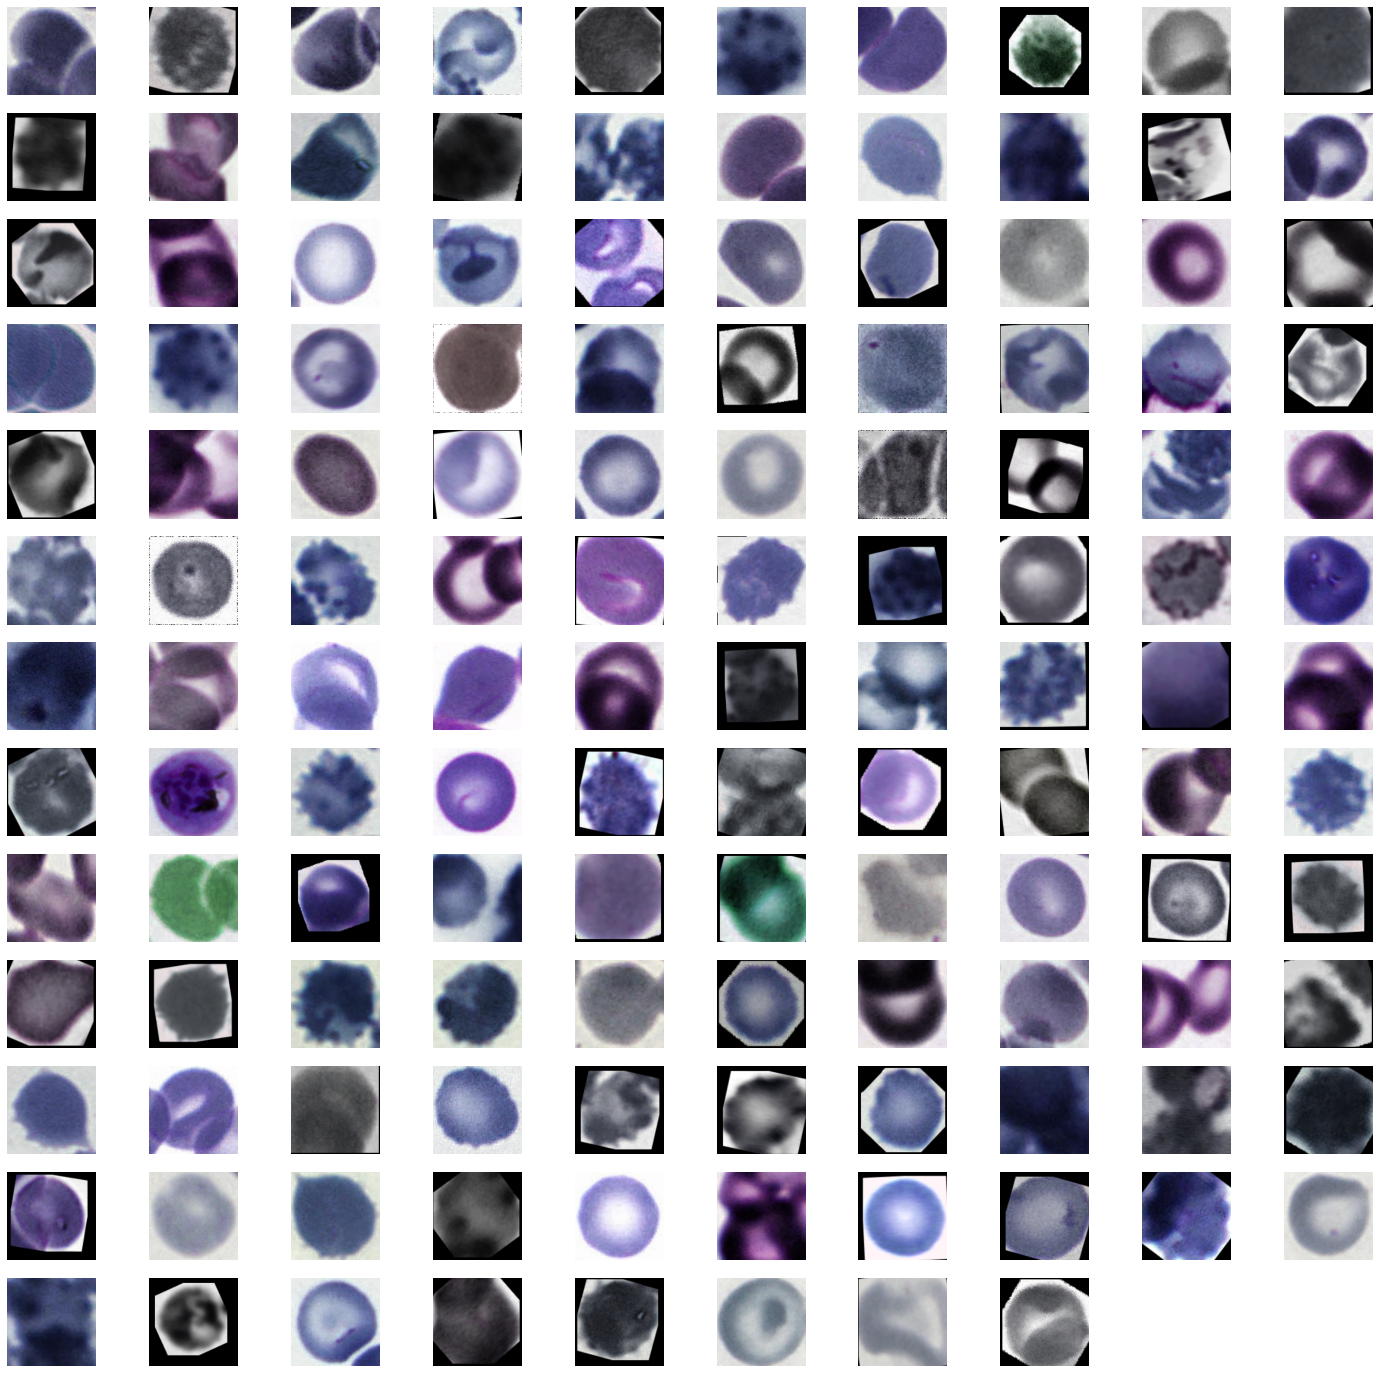

In [41]:
# Visualize train pictures
images = np.vstack([train_sequence[i][0] for i in range(2)])
images_per_row = 10
fig = plt.figure(figsize=(25, 25))
gs = fig.add_gridspec(int(np.ceil(len(images) / images_per_row)), images_per_row)

for i in range(len(images)):
    ax = fig.add_subplot(gs[i // images_per_row, i % images_per_row])
    ax.axis('off')
    ax.imshow(images[i], cmap='gray')

plt.show()

# Create Model

In [42]:
model = create_model((*CROP_SIZE, 3), num_classes, verbose=True)

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_4 (Tenso [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_4 (TensorFlo [(None, 150, 150, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
GlobalAvgPool2D (GlobalAvera (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_24 (Batc (None, 1024)              4096  

# Train Model

In [46]:
def focal_loss(gamma=2.0):
    def loss(y_true, y_pred):
        p = tf.reduce_sum(y_true * y_pred, axis=-1)
        out = -tf.reduce_mean(tf.pow(1.0 - p, gamma) * tf.math.log(p + 1e-9))
        return out
    return loss

model.compile(
    optimizer = K.optimizers.Adam(lr=5e-5),
    loss = focal_loss(gamma=2),
    weighted_metrics = [K.metrics.CategoricalAccuracy(name='acc')],
)

In [35]:
# model.load_weights('./checkpoints/class-20201218-053427/16_0.0210_0.0818.h5', by_name=False)  # 4 classes best result
model.load_weights('./checkpoints/class-20201218-074154/100_0.1106_0.0967.h5', by_name=False)  # All classes best result

In [36]:
today = datetime.now().strftime('%Y%m%d-%H%M%S')
checkpoint_base_path = f'checkpoints/class-{today}'
if not osp.exists(checkpoint_base_path):
    os.makedirs(checkpoint_base_path)
print(f'Save checkpoints in {checkpoint_base_path}')

result = model.fit(
    x = train_sequence,
    shuffle = True,
    initial_epoch = 0,
    epochs = 25,
    steps_per_epoch = 200,
    verbose = 1,
    validation_data = val_sequence,
    max_queue_size = 5,
    workers = 10,
    use_multiprocessing = False,
    class_weight = {i: w for i, w in enumerate(train_sequence.class_weights)},
    callbacks = [
        K.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1,
                                      mode='min', min_delta=1e-4, min_lr=1e-7),
        K.callbacks.ModelCheckpoint(
            osp.join(checkpoint_base_path, '{epoch:02d}_{loss:.4f}_{val_loss:.4f}.h5'),
            verbose = 0,
            save_weights_only = True,
        ),
    ],
)

Save checkpoints in checkpoints/class-20201218-161027
Epoch 1/25
200/200 [==============================] - 41s 206ms/step - loss: 1.7824 - acc: 0.8305 - val_loss: 0.2803 - val_acc: 0.9174
Epoch 2/25
200/200 [==============================] - 40s 198ms/step - loss: 0.3503 - acc: 0.9136 - val_loss: 0.2636 - val_acc: 0.9349
Epoch 3/25
200/200 [==============================] - 41s 204ms/step - loss: 0.2360 - acc: 0.9240 - val_loss: 0.2461 - val_acc: 0.9531
Epoch 4/25
200/200 [==============================] - 42s 208ms/step - loss: 0.1653 - acc: 0.9302 - val_loss: 0.2366 - val_acc: 0.9582
Epoch 5/25
200/200 [==============================] - 40s 200ms/step - loss: 0.1594 - acc: 0.9155 - val_loss: 0.1706 - val_acc: 0.9607
Epoch 6/25
200/200 [==============================] - 40s 200ms/step - loss: 0.1480 - acc: 0.9372 - val_loss: 0.1866 - val_acc: 0.9592
Epoch 7/25
200/200 [==============================] - 40s 202ms/step - loss: 0.1342 - acc: 0.9080 - val_loss: 0.1785 - val_acc: 0.9617
E

In [55]:
def draw_confusion_matrix(y_true, y_pred):
    ticklabels = ['gametocyte', 'leukocyte', 'red blood cell', 'ring', 'schizont', 'trophozoite', 'false positive']
    plt.figure(figsize=(20, 15))
    cf_matrix = confusion_matrix(y_true, np.argmax(y_pred, axis=1), labels=range(num_classes), normalize='true')
    _ = sns.heatmap(cf_matrix, annot=True, xticklabels=ticklabels, yticklabels=ticklabels, cmap='YlGnBu')

model.load_weights('./checkpoints/class-20201218-074154/100_0.1106_0.0967.h5', by_name=False)  # All classes best result

In [56]:
y_true = val_sequence.y[val_sequence.indexes]
y_pred = model.predict(val_sequence, verbose=1)
model.evaluate(val_sequence, verbose=1)

284/284 [==============================] - 11s 40ms/step - loss: 0.0967 - acc: 0.9536


[0.09670640528202057, 0.9535588622093201]

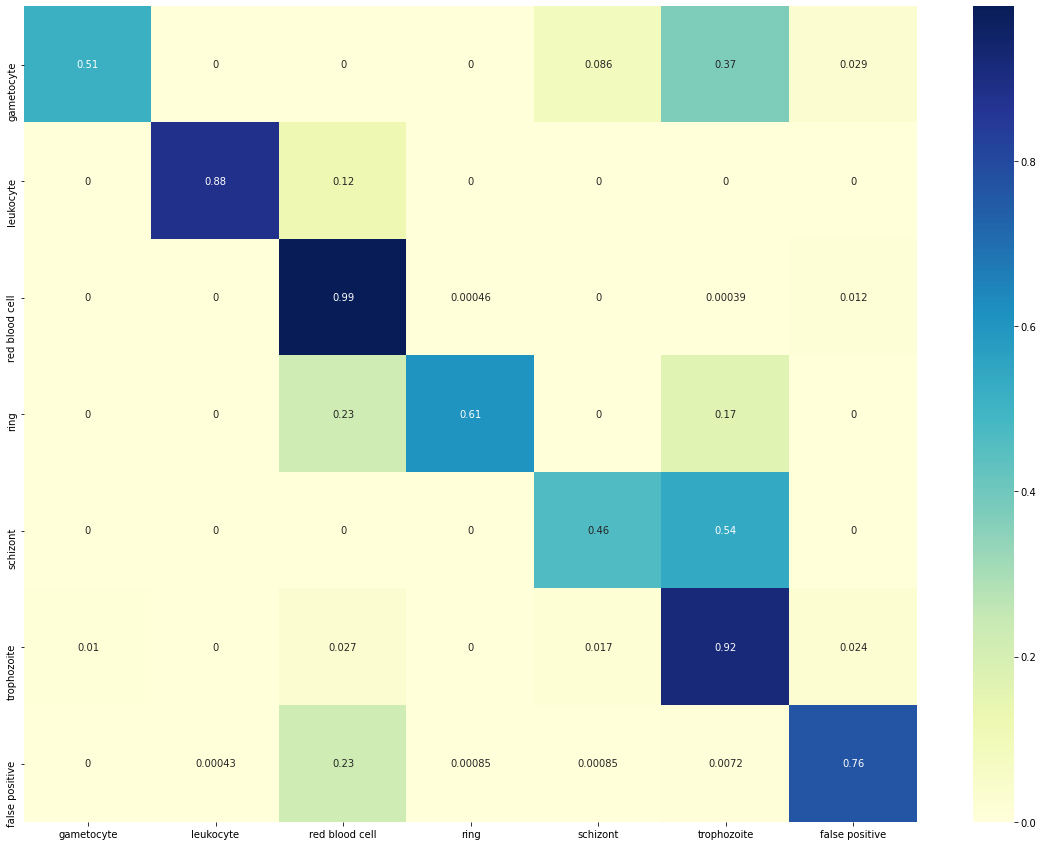

In [57]:
draw_confusion_matrix(y_true, y_pred)

In [58]:
y_true = test_sequence.y[test_sequence.indexes]
y_pred = model.predict(test_sequence, verbose=1)
model.evaluate(test_sequence, verbose=1)

105/105 [==============================] - 4s 38ms/step - loss: 0.1628 - acc: 0.9247


[0.16277405619621277, 0.9246667623519897]

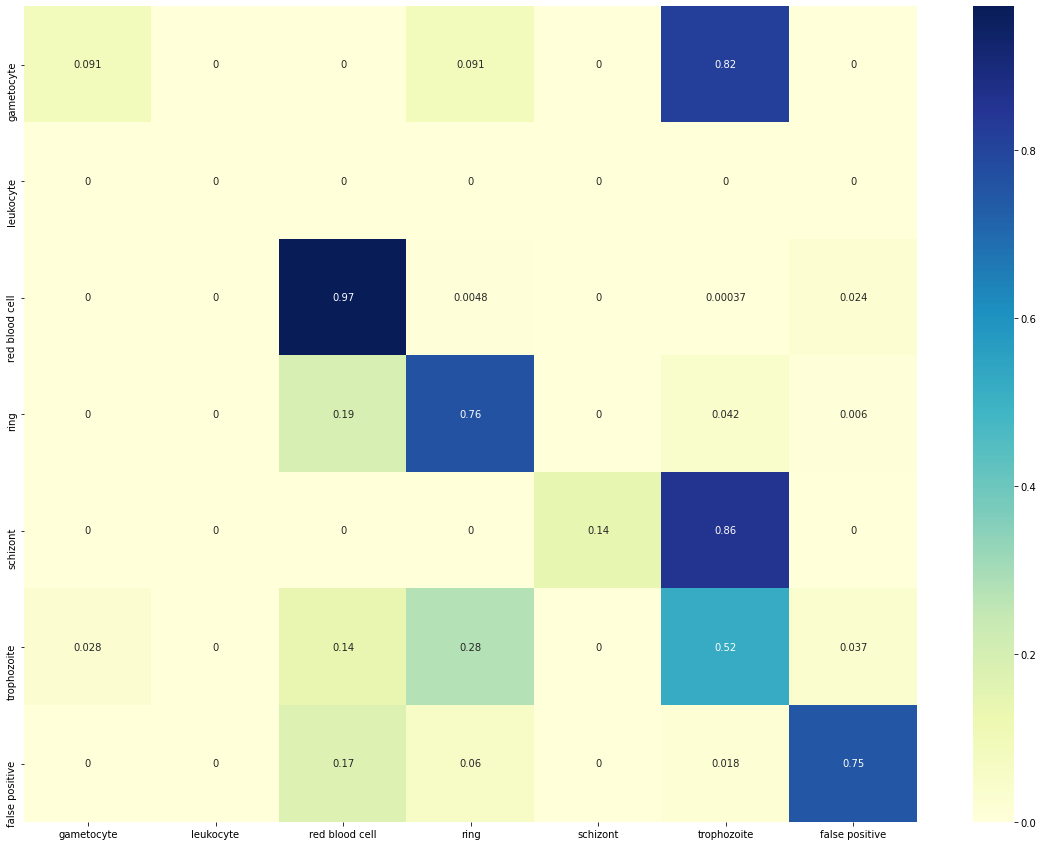

In [59]:
draw_confusion_matrix(y_true, y_pred)